# Galactic Mapping

In [1]:
# Setup data retrieval
from lab_4_data_loading import fits_ell

from numpy import arange
ell_values = arange(-8,250,2)

from freqs import freqs
freqs = freqs().value

In [48]:
# Visualization
import matplotlib.pyplot as plt
from set_mpl import set_mpl
set_mpl()
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib as mpl
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import matplotlib.cm as cm

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# All the data manipulation functions, and a few ancillary ones
from data_manipulation import *

from multiple_peak_finder import multiple_peak_finder

## Plot data for one $\ell$ 

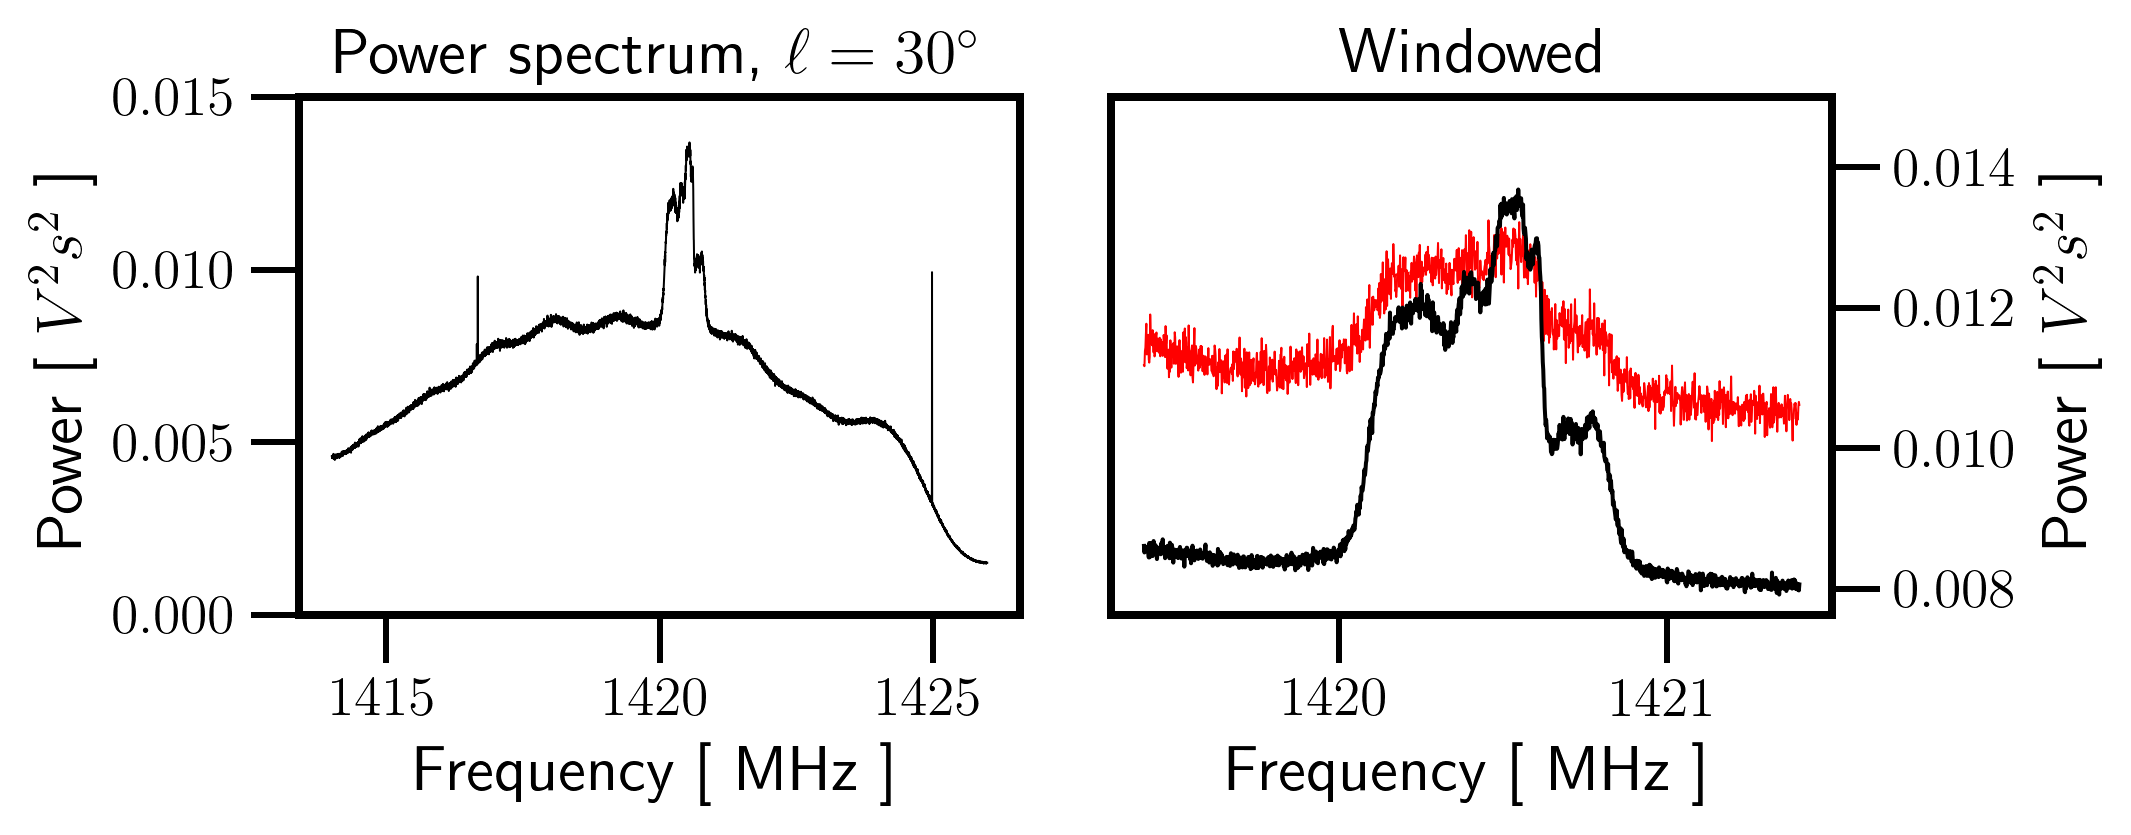

In [4]:
# Representative Plot
fig, axes = plt.subplots(1,2, figsize = (7.5,3), dpi = 144)

ax = axes[0]

ax.plot(freqs, fix_zeros(mean_spectra(fits_ell(30), combine = False)), lw = 0.5, color = 'black')

ax.set_xlabel('Frequency [ MHz ]')
ax.set_ylabel(r'Power [ $V^2 s^2$ ] ')
ax.set_title(r'Power spectrum, $\ell = 30^\circ$')
ax.set_ylim(0,0.015)


ax = axes[1]

ax.plot(freqs_window, spectra_in_window(mean_spectra(fits_ell(30, noise_off = False), combine = False)), lw = 0.5, color = 'red')
ax.plot(freqs_window, spectra_in_window(mean_spectra(fits_ell(30), combine = False)), lw = 1, color = 'black')

ax.set_xlabel('Frequency [ MHz ]')
ax.set_ylabel(r'Power [ $V^2 s^2$ ] ')
ax.set_title(r'Windowed')
ax.set_ylim(top = 0.015)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

plt.tight_layout()
# fig.savefig('ell_30_powerll.png', dpi = 320, bbox_axes = 'tight', format = 'png')
plt.show()

> Representative mean power spectra for our observations. Left: the mean of 20 power spectra for $\ell = 30^\circ$. Right: the same mean power spectrum in a smaller frequency window, with the mean of 4 noise spectra (red). In the left plot we see the HI signal shape jutting out of a broad base due to our signal chain. We also note two high power narrow frequency spikes, possibly intercepted radio stations. The shape of the signal chain has a wave component that is quite difficult to eliminate. In the right plot we see that by narrowing our window to $\nu_\text{HI} \pm$ MHz we can reveal more clearly the shape of the HI signal.

128, 1363

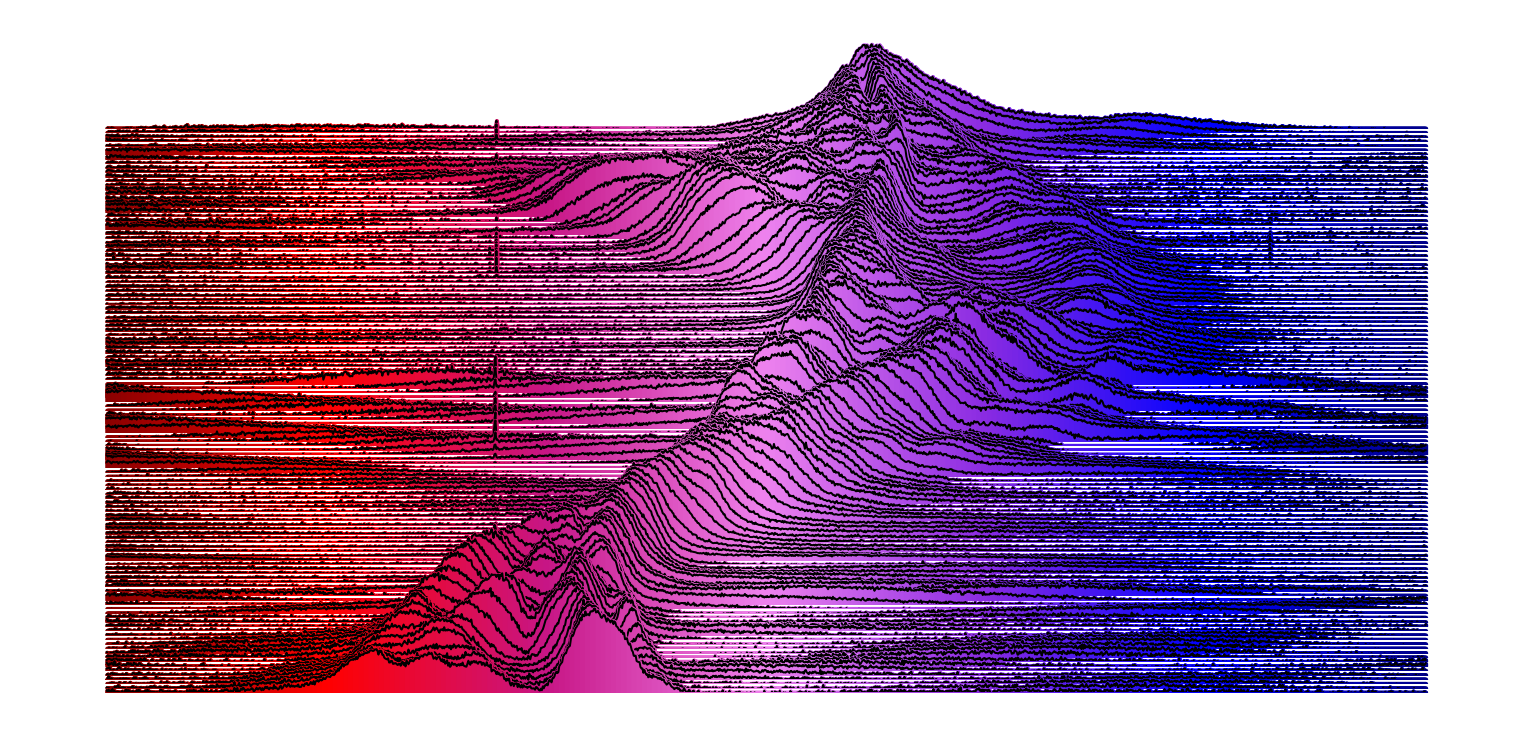

In [9]:
# ridgeline plot off all data with doppler shift
fig, axes = plt.subplots(len(ell_values),1, figsize = (6.5,3), facecolor='w', dpi = 144)

colorlist = ["darkblue","blue","blueviolet","violet","mediumvioletred", "red","darkred"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("", colorlist)

x = freqs_in_window(L = 1419.405751786, R = 1421.405751786)
z = -x

normalize = mpl.colors.Normalize(vmin=z.min(), vmax=z.max())

for i, ax in enumerate(axes.reshape(-1)):
    ell = ell_values[i]
    y = shift(spectra_in_window(mean_spectra(fits_ell(ell))))
    
    ax.plot(x, y, lw = 0.5, color = 'k')

    for j in range(len(x) - 1):
        ax.fill_between([x[j], x[j+1]], [y[j], y[j+1]], color=cmap(normalize(z[j])))
        sys.stdout.write('\r'+str('%d, %d' %(i,j))) 
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylim(0)
    ax.axis('off')
    
#     if ell % 25 == 0:
#         ax.set_ylabel(str(ell), rotation = 0, labelpad = 20)
#         ax.yaxis.set_label_coords(-.01, 0)
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-.95)

# fig.savefig('blue_red_shift_plot.pdf', format = 'pdf', dpi = 320)

plt.axis('off')

plt.show()

> 129 observation spectra with Doppler shift indicated by color. For clarity, here each power spectrum has had a simple second order polynomial fitted and subsequently subtracted from it. By presenting the spectra in this form we are able to view how the spectra shift and change shape depending on $\ell$. We see structure here, indicating that the hydrogen clouds the signals originate from also have structure.

To convert from frequency to velocity we use the standard equation and take into account the velocity of the local standard of rest.

\begin{align}
v_\text{corr} &= -c\cdot\left(\frac{\Delta\nu}{\nu_\text{HI}}\right) - v_\text{LSR}\\
&= -c\cdot\left(\frac{\nu_\text{meas} - \nu_\text{HI}}{\nu_\text{HI}}\right) - v_\text{LSR}
\end{align}

where $\nu_\text{meas}$ is the measured frequency, $\nu_\text{HI}$ is the actual hydrogen frequency, and $v_\text{LSR}$ is the veloctiy of the local standard of rest.

To find the intensity of the hydrogen we need the gain of the signal chain. The gain G is the difference between the noise and power spectra divided by the temperature of the noise diode:

\begin{equation}
G = \frac{P_\text{noise} - P_\text{measured}}{T_\text{noise}}
\end{equation}

And the intensity is just the measured power divided by the mean of the gain.

\begin{equation}
I = \frac{P_\text{measured}}{g}
\end{equation}

where $g = \bar{G}$ and $I$ is the intensity in Kelvin.

128

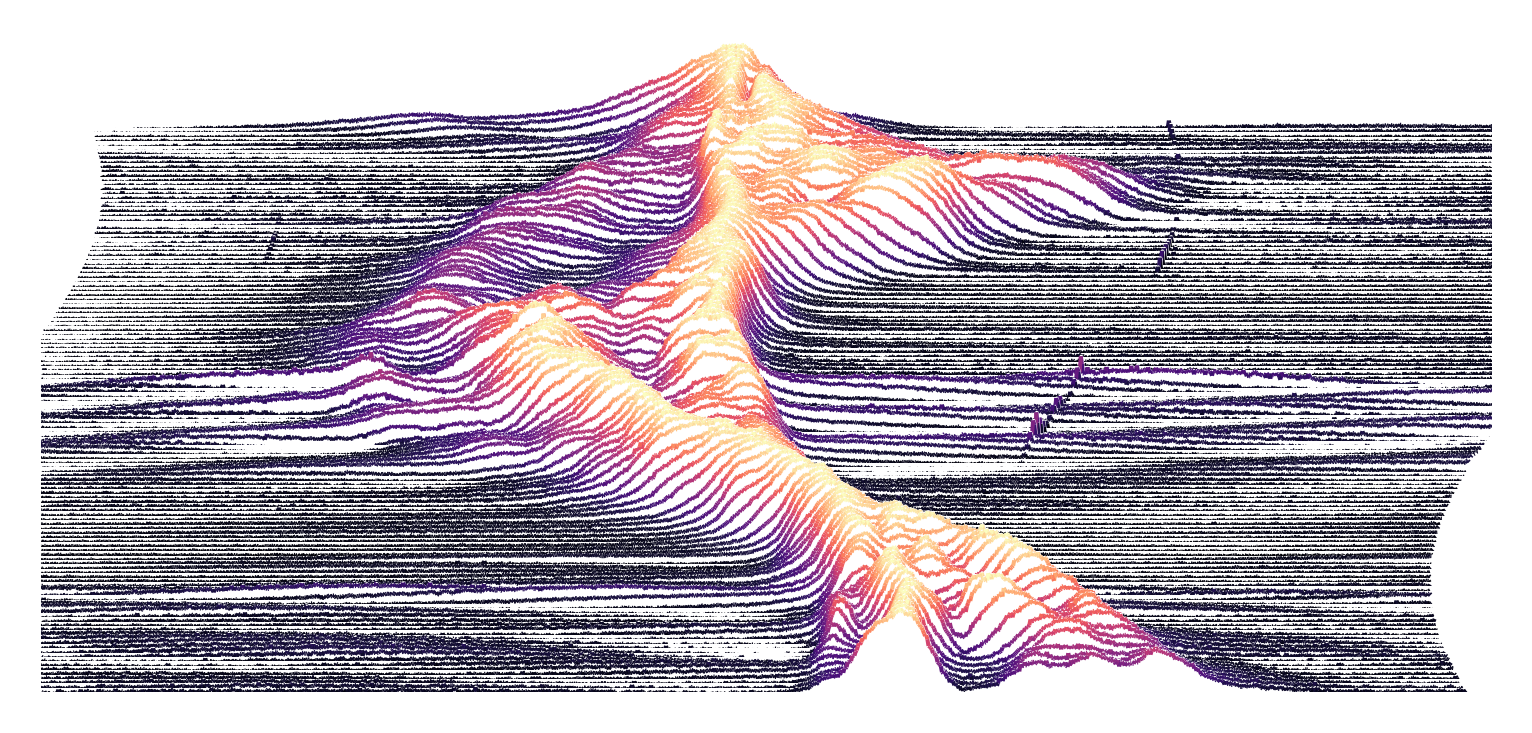

In [11]:
# Intensity Calibration Plot
fig, axes = plt.subplots(len(ell_values),1, figsize = (6.5,3), facecolor='white', dpi = 144)

for i, ax in enumerate(axes.reshape(-1)):

    ell = ell_values[i]

    ax.axis('off')
    x = corrected_velocity(ell)#np.linspace(0,100,100)
    y = shifted_intensity(ell, combine = False)#2 * np.linspace(0,100,100)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    path = mpath.Path(np.column_stack([x, y]))
    verts = path.interpolated(steps=3).vertices
    
    x, y = verts[:, 0], verts[:, 1]
    normalize = mpl.colors.Normalize(vmin=0, vmax=250)
    arr_color = cm.ScalarMappable(cmap = cm.magma).to_rgba(shifted_intensity(ell, combine = False))
    
    lc = mcoll.LineCollection(segments,
                              colors = arr_color, norm = normalize,
                              cmap = cm.magma, linewidths = 1)
    
    ax.add_collection(lc)
    
    ax.fill_between(corrected_velocity(ell), shifted_intensity(ell, combine = False), 0, interpolate = True, color = 'white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(-200,200)
    ax.set_ylim(0)
    sys.stdout.write('\r'+str('%d' %i )) 
    

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-.95)
plt.axis('off')
# fig.savefig('vel_intens_ell.pdf', format = 'pdf', dpi = 320)
# fig.savefig('vel_intens_ell.png', format = 'png', dpi = 320)

plt.show()

> 129 calibrated observation profiles with intensity indicated by color. Each spectra has been calibrated using (the intensity equation) and has had a second order polynomial fit removed. The velocity data was computed using (the velocity correction equation). The curved whitespace visible in the lower right corner is caused by the adjustment $v_\text{LSR}$, different for each observation. After calibration the structure noted in (the ridgeline plot with the doppler shift) remains visible, and the high intensity peaks are easy to follow along the structure.

We have inferred velocites for each $\ell$, but what do we expect?

\begin{align}
v_\text{exp} &= \vec{v}_{\text{01}}\cdot\hat{r}_{\text{01}} \nonumber\\
 &= (\vec{v}_{\text{1}} - \vec{v}_{\text{0}})\cdot\frac{(\vec{r}_{\text{1}} - \vec{r}_{\text{0})}}{|(\vec{r}_{\text{1}} - \vec{r}_{\text{0}})|} 
\end{align}

where r0 is the position of the sun, v0 is its velocity. r1 and v1 are the position and velocity of a point in the galaxy (origin is center of the galaxy)

In [23]:
# setup expected velocity space
ell = 30
R = 30

num_x = num_y = 1000
x_galactic = linspace(-R,R,num_x)
y_galactic = linspace(-R,R,num_y)

vel_grid = make_vel_grid(x_galactic, y_galactic,R = R)

1, 701

999, 999

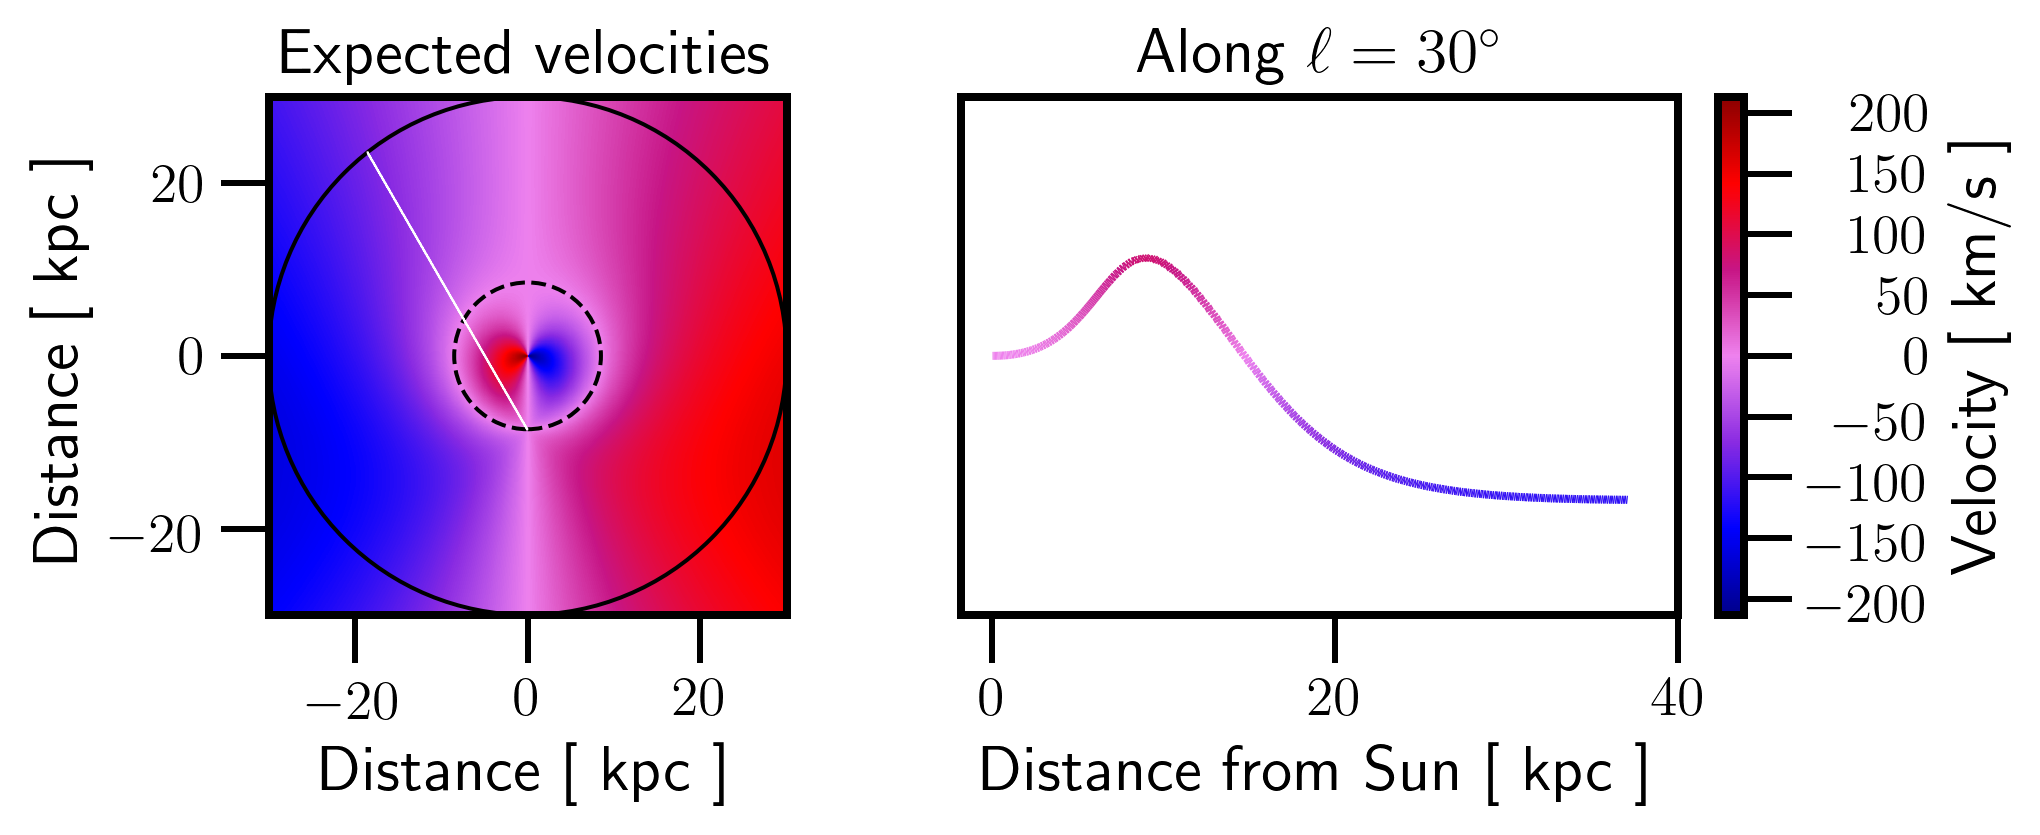

In [41]:
# plot of expected velocities
x, y = radial_line(-ell, R= R)
x_line_indices, y_line_indices = x_y_indicies_along_line(ell, x,y, x_galactic, y_galactic, R = R)

fig, axes = plt.subplots(1,2, figsize = (7.5,3), dpi = 144)
immmm = axes[0].imshow(vel_grid, extent = [-R, R, -R, R], cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["darkblue","blue","blueviolet","violet","mediumvioletred", "red","darkred"]))

ax = axes[0]

ax.add_artist(plt.Circle((0, 0), 8.5, color= 'black', fill = False, ls = '--'))
ax.add_artist(plt.Circle((0, 0), R, color= 'black', fill = False, ls = '-'))

ax.plot(x_galactic[x_line_indices],y_galactic[y_line_indices], color = 'white', drawstyle="steps-post", lw = 0.5)

ax.set_title('Expected velocities')
ax.set_xlabel('Distance  [ kpc ]')
ax.set_ylabel('Distance  [ kpc ]')

ax = axes[1]

ell = 30
xx, yy = radial_line(-ell, R= R)

x_line_indices, y_line_indices = x_y_indicies_along_line(ell, x,y, x_galactic, y_galactic, R = R)

savethis = expected_velocities(ell, xx, yy, x_galactic, x_galactic, vel_grid = vel_grid)
y = expected_velocities(ell, xx, yy, x_galactic, x_galactic, vel_grid = vel_grid)

x = expected_distances(len(y), xx, yy)

ax.plot(x, y, visible = False)


points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

path = mpath.Path(np.column_stack([x, y]))
verts = path.interpolated(steps=3).vertices

x, y = verts[:, 0], verts[:, 1]
cmap_mine = mpl.colors.LinearSegmentedColormap.from_list("", ["darkblue","blue","blueviolet","violet","mediumvioletred", "red","darkred"])

normalize = mpl.colors.Normalize(vmin=-220, vmax=220)

arr_color = cm.ScalarMappable(cmap = cmap_mine, norm = normalize).to_rgba(savethis)

lc = mcoll.LineCollection(segments,
                          colors = arr_color,
                          cmap = cmap_mine,linewidths = 2,norm = normalize)

ax.add_collection(lc)

ax.set_title(r'Along $\ell = 30^\circ$')
ax.set_xlabel('Distance from Sun [ kpc ]')
ax.set_yticks([])

ax.set_ylim(-220,220)
ax.set_xlim(right = 40)





cbar = plt.colorbar(immmm, fraction=0.045)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs,ha='right')
cbar.ax.yaxis.set_tick_params(pad=35)
cbar.set_label('Velocity [ km/s ]')

plt.tight_layout()
# fig.savefig('expected_vels_302.png', dpi = 320, bbox_inches = 'tight', format = 'png')
# fig.savefig('expected_vels_302.pdf', dpi = 320, bbox_inches = 'tight', format = 'pdf')
plt.show()

> Left: the velocities we expect to observe at many points, the great solar circle (dashed), a reference line at R = 30 (black), and the line of sight for $\ell = 30^\circ$ (white). Right: The velocities we expect to observe along $\ell = 30^\circ$. Using Equation (the expected velocity equation) we compute $v_\text{exp}$ for every point in a 2D grid of coordinates. The resulting 2D array of velocities will allow us to create a distance-velocity map. For each $\ell$ we extract the corresponding velocities from the 2D velocity array. The distances for each point are computed with light trigonometry. With these values we will be able to map our computed intensities to distances from the Sun.

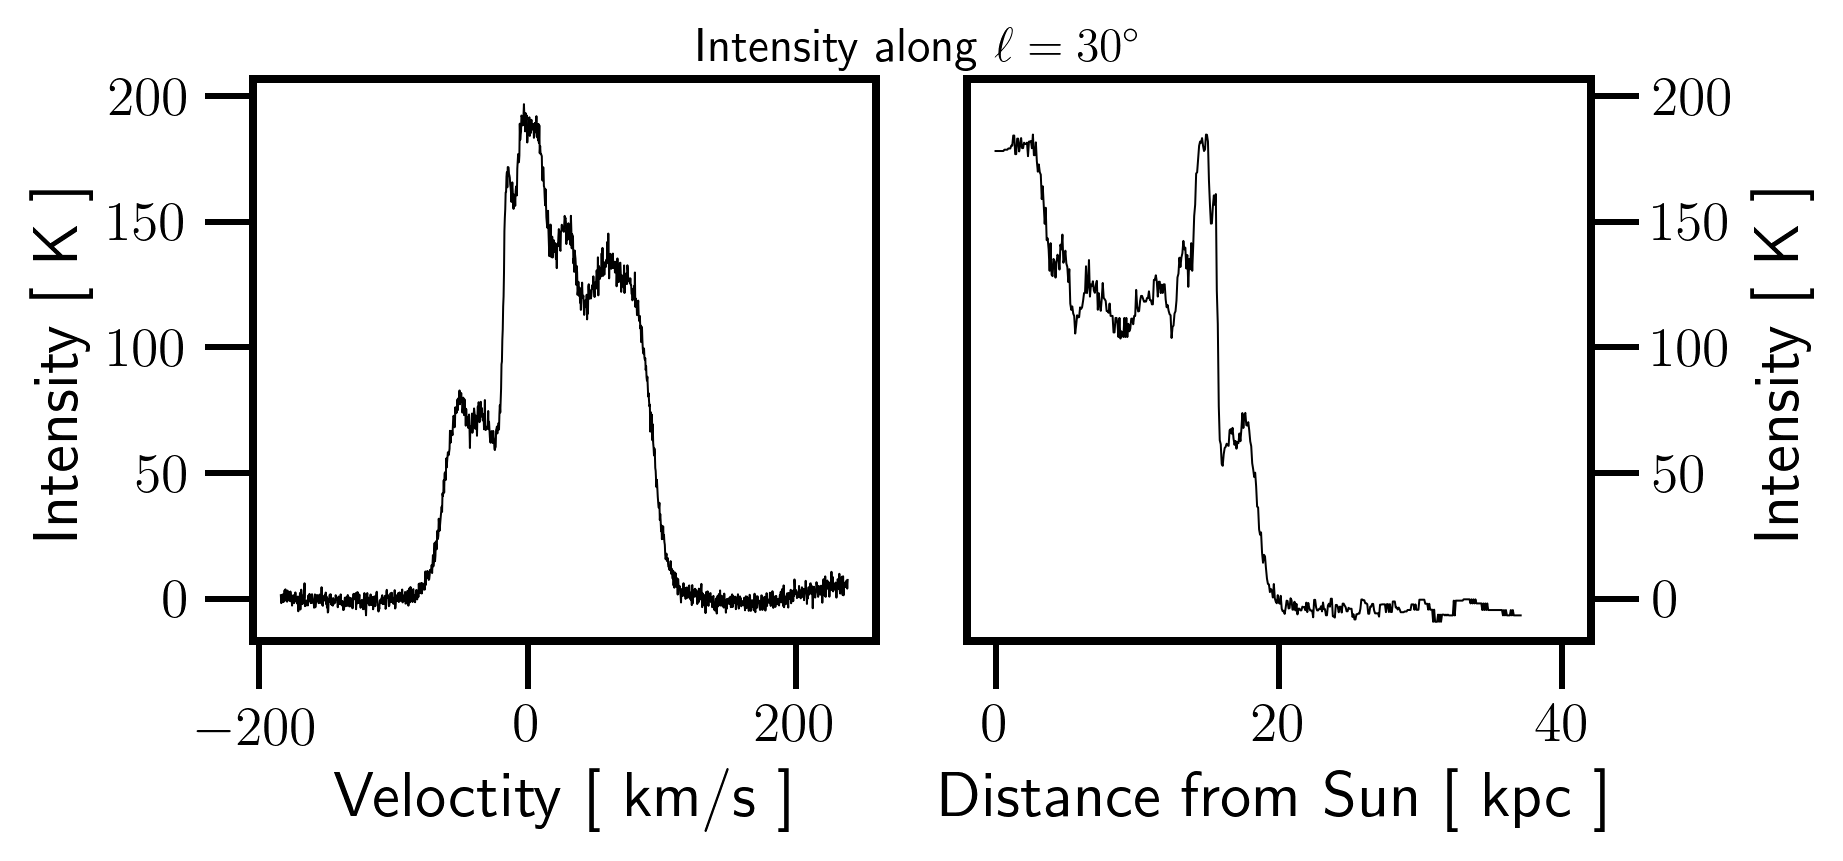

In [47]:
# plot intensities against velocity and the corresponding distances
x, y = radial_line(-ell, R= R)
x_line_indices, y_line_indices = x_y_indicies_along_line(ell, x,y, x_galactic, y_galactic, R = R)


red_line_vels = expected_velocities(ell, x, y, x_galactic, y_galactic, vel_grid = vel_grid)

red_line_distances = expected_distances(len(red_line_vels), x, y)

fig, axes = plt.subplots(1,2, figsize = (6.5, 3), dpi = 144)

axes[0].plot(corrected_velocity(ell),
        shifted_intensity(ell, 
                          combine = False,
                          mean_g = True), lw = 0.5, color = 'black')


fig.suptitle(r'Intensity along $\ell = 30^\circ$')
axes[0].set_ylabel('Intensity [ K ]')
axes[0].set_xlabel('Veloctity [ km/s ]')

axes[1].plot(red_line_distances,
             map_intensities_to_distance(red_line_vels,red_line_distances, ell, median_y = False, combine = False),
             color = 'black', lw = 0.5)
axes[1].set_ylim(axes[0].get_ylim())
axes[1].set_ylabel('Intensity [ K ] ')
axes[1].set_xlabel('Distance from Sun [ kpc ]')
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
axes[1].set_xlim(-2,42)
plt.tight_layout()

# fig.savefig('vel_and_distance.pdf', format = 'pdf', dpi = 320, bbox_axes = 'tight')
# fig.savefig('vel_and_distance.png', format = 'png', dpi = 320, bbox_axes = 'tight')
plt.show()

> Comparison of a calibrated intensity-velocity profile with the corresponding intensity-distance curve. By relating intensity to velocity and velocity to distance, we are able to relate intensity to distance. Left: Calibrated intensities and their corresponding corrected velocities. Right: Calibrated intensities with their velocities mapped to the corresponding distances. We see that the signal shape has been altered by the translation process, and a portion of the shape has been truncated. This truncation occurs because though our data shows velocities from -200km/s  to 220 km/s our map indicates a smaller range. The intensity values with velocities outside this range have nowhere to map to, and are discarded.

In [51]:
# setup scatterpoints for galaxy plot
point_array_s = []

for i, ell in enumerate(ell_values):
    
    x, y = radial_line(-ell, R= R)
    x_line_indices, y_line_indices = x_y_indicies_along_line(ell, x,y, x_galactic, y_galactic, R = R)
     
    red_line_vels = expected_velocities(ell, x, y, x_galactic, y_galactic, vel_grid = vel_grid)
    red_line_distances = expected_distances(len(red_line_vels), x, y)
    
    intensity_along_redline = map_intensities_to_distance(red_line_vels, red_line_distances, ell, median_y = False, combine=False)
        
    
    for j, dist in enumerate(red_line_distances):     
    
        point_array_s.append([((cos((ell + 90) * deg) * red_line_distances[j]).value,(sin((ell + 90) * deg) * red_line_distances[j]).value,intensity_along_redline[j], red_line_distances[j])])
        sys.stdout.write('\r'+str('%d, %d' %(i, j) )) 

# sort the points by color (brightest first)
point_array_s2 = sorted(point_array_s, key = lambda element : element[0][2], reverse=True)

ppxx = array(point_array_s2).T[0]
ppyy = array(point_array_s2).T[1]
ppcc = array(point_array_s2).T[2]
ppss = array(point_array_s2).T[3]

128, 398

In [52]:
# plot of the galaxy R = 30

fig, ax  = plt.subplots(figsize = (7 *1.05,7), dpi = 144)


im = ax.scatter(ppxx, ppyy - 8.5, c = ppcc, s= ppss*2, cmap = 'magma',)

ax.add_artist(plt.Circle((0, 0), 31, color= 'white', fill = False, ls = '-', lw = 5))
ax.set_xlabel('Distance [ kpc ]')
ax.set_ylabel('Distance [ kpc ]')
ax.set_title('Galactic map')


ax.set_xlim(-35, 35)
ax.set_ylim(-35, 35)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax = cax)
cbar.set_label('Intensity [ K ]')

# fig.savefig('galaxy_map.pdf', format = 'pdf', dpi = 320, bbox_inches = 'tight')
# fig.savefig('galaxy_map.png', format = 'png', dpi = 320, bbox_inches = 'tight')


ax.set_aspect('equal')
plt.show()


> Map of the galaxy generated by mapping intensity to distance for observations along each $\ell$. This image is a scatter plot of 54168 points, sorted by intensity. Large scale structures are visible wrapping around the galaxy in arcs. Comparing to existing maps of the galaxy these structures may be the Perseus Arm and Sagittarius Arm. In order to see more structure, our velocity grid and this map have the galactic radius set to 30 kilo parsecs, double the accepted value. We believe that our simplistic position-velocity map is the cause of this discrepancy.